#Introducción

Este proyecto se ha realizado con el objetivo de familiarizarse con tareas de redes sociales y los instrumentos usados para ello como parte del módulo de Text mining y redes sociales impartido por Luis Gascó en el Máster Data Science, Big Data & Business Analytics de la Universidad Complutense de Madrid.

Se a formateado la notebook con respecto a la generada para la tarea con el objetivo de simplificar su visualización.

El proyecto se compone del análisis topológico, de conectividad de red y de relevancia de nodos, y su representación gráfica por medio de NetworkX, de una [base de datos](https://github.com/luisgasco/ntic_master_datos/files/10912179/datos_ejercicio_twitter.zip) generada por [Luis Gascó](https://github.com/luisgasco) y basada en la reducción de la shared-task [SocialDisNER](https://temu.bsc.es/socialdisner/) (celebrada en el año 2022), eligiendo un conjunto de 100 cuentas seed, de las que se descargaron sus seguidores y los seguidores de sus seguidores y filtrando algunas de las cuentas.

# 0. Imports

In [ ]:
# Cargamos e instalamos librería que se utilizará
!pip install networkx[default]
!pip install matplotlib==3.1.3
!pip install scipy==1.10.1

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
import random
import string
import pandas as pd
import seaborn as sns
import numpy as np

# 1. Descarga y carga de datos

## Descargamos los datos

Descargamos los datos y los descomprimimos.

In [ ]:
!wget https://github.com/luisgasco/ntic_master_datos/files/10912179/datos_ejercicio_twitter.zip
!unzip datos_ejercicio_twitter.zip

## Cargamos los nodos y las aristas

In [ ]:
nodos = pd.read_csv("nodos_ejercicio.tsv",sep="\t")
aristas = pd.read_csv("aristas_ejercicio.tsv",sep="\t")

Eliminamos dos nodos de los datos cargados, ya que si no obtendremos un subgrafo dirigido con dos componentes, que no entra dentro del propósito del proyecto. Quitando dos nodos (que previamente he comprobado que son los que generan el segundo componente) conseguiremos un grafo con un único componente:

In [ ]:
nodos = nodos[~nodos.Target.isin([187715558, 201414730])].copy()
aristas = aristas[~aristas.Target.isin([187715558, 201414730])].copy()

Observamos las columnas que componen el dataset aristas, establecemos una copia de la columna Target como indice coincidente en ambos datasets (id_source).

## Fijamos índices comunes

Observamos las columnas que componen el dataset y establecemos una copia de la columna Source como indice coincidente en ambos datasets (id_source)

In [ ]:
aristas.head()
aristas["id_source"]=aristas.Source
aristas=aristas.set_index("id_source")
aristas.head(1)

,Source,Target
id_source,,
2838611488,2838611488,920282323446312960


Observamos las columnas que componen el dataset nodos y establecemos una copia de la columna Target como indice coincidente en ambos datasets (id_source).


In [ ]:
nodos.head()

nodos["id_source"]=nodos.Target
nodos=nodos.set_index("id_source")
nodos.head(1)

,Target,description,grupo
id_source,,,
920282323446312960,920282323446312960,Perfil oficial de la Asociación Española de La...,asociacion


In [ ]:
nodos.groupby("grupo").size()

grupo
asociacion    332
fundacion      17
no_class      206
ong            35
dtype: int64

## Creamos el grafo

Componemos el grafo en base a la lista de aristas, añadimos los nodos de la lista nodos y comprobamos la existencia de direccionalidad

In [ ]:
G = nx.from_pandas_edgelist(aristas, "Source","Target", create_using=nx.DiGraph())
G.add_nodes_from(nodos)
G.is_directed()

True

# 2. Análisis topológico

## Mostramos el conteo de aristas y nodos del grafo

In [ ]:
print("Dentro de este grafo hay un total de {} nodos (que representan cuentas).\n".format(G.number_of_nodes()))
print("En el grafo hay un total de {} aristas diferentes (que representan relaciones entre cuentas).".format(G.number_of_edges()))

Dentro de este grafo hay un total de 625 nodos (que representan cuentas).

En el grafo hay un total de 10122 aristas diferentes (que representan relaciones entre cuentas).


## Representamos los 20 nodos con mayor número de seguidores y los 20 con mayor número de seguidos

Obtenemos diccionarios de nodos ordenados según el número de seguidores y seguidos para representar aquellos con mayor cantidad.

Filtramos ambos diccionarios para obtener los cinco primeros.

Creamos subplots para representar ambos en una misma línea y transformamos en datasets los diccionarios y la columna usuarios en cadenas de texto.

Establecemos el primer gráfico de barras, que representa top_seguidores, fijando sus valores en la parte superior de las columnas, su título, las condiciones en las etiquetas del eje X y su longitud representada en el eje Y. Repetimos el proceso adaptándonos a las condiciones del segundo gráfico de barras, top_seguidos.

Por último, ajustamos el tamaño del conjunto de gráficos y visualizamos el resultado.

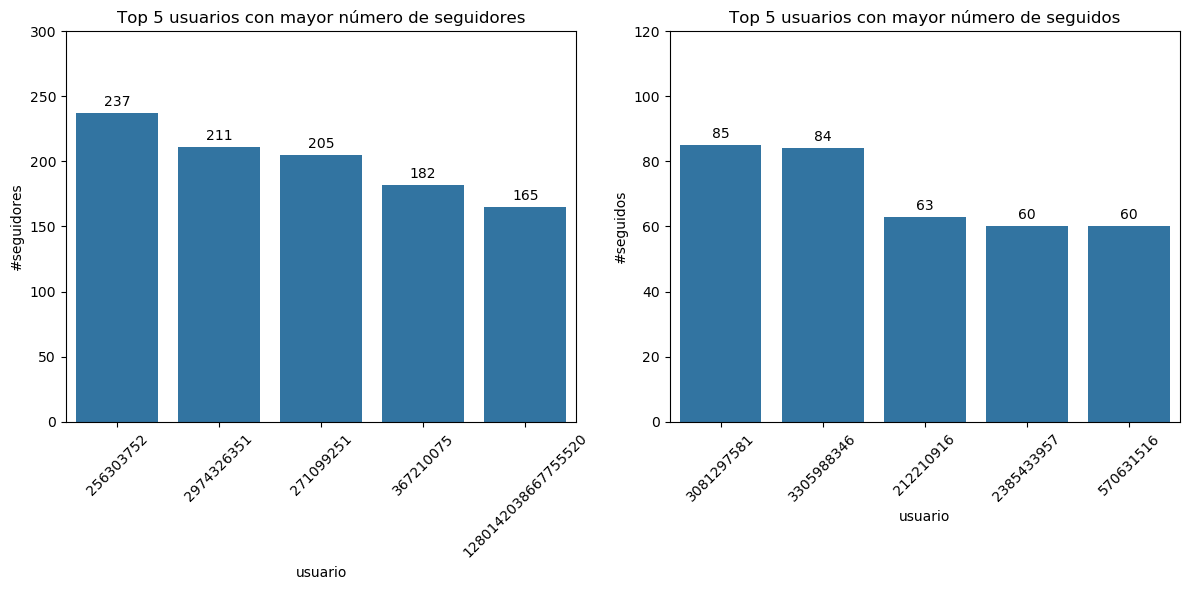

In [ ]:
dict_seguidores = sorted(G.in_degree(), key=lambda x: x[1],reverse=True)
dict_seguidos= sorted(G.out_degree(), key=lambda x: x[1],reverse=True)

top_seguidores = dict_seguidores[:5]
top_seguidos = dict_seguidos[:5]

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

df1 = pd.DataFrame(top_seguidores, columns=["usuario", "#seguidores"])
df1.usuario = df1.usuario.astype(str)
df2 = pd.DataFrame(top_seguidos, columns=["usuario", "#seguidos"])
df2.usuario = df2.usuario.astype(str)

sns.barplot(data=df1, x="usuario", y="#seguidores", ax=axes[0])
axes[0].set_title("Top 5 usuarios con mayor número de seguidores")
axes[0].tick_params(axis='x', rotation=45, labelsize=10)

for index, row in df1.iterrows():
    axes[0].annotate(f"{row['#seguidores']}", (index, row['#seguidores']),
                     xytext=(0, 3), textcoords='offset points',
                     ha='center', va='bottom')

axes[0].set_ylim(0, 300)

sns.barplot(data=df2, x="usuario", y="#seguidos", ax=axes[1])
axes[1].set_title("Top 5 usuarios con mayor número de seguidos")
axes[1].tick_params(axis='x', rotation=45, labelsize=10)

for index, row in df2.iterrows():
    axes[1].annotate(f"{row['#seguidos']}", (index, row['#seguidos']),
                     xytext=(0, 3), textcoords='offset points',
                     ha='center', va='bottom')

axes[1].set_ylim(0, 120)

plt.tight_layout()

plt.show()

# 3. Conectividad de red

## Comprobamos la conectividad de red

Comprobamos que todos los elementos de la red pueden llegar al resto de vértices. Utilizamos ".is_semiconnected(G)" en vez de ".is_connected(G)" dado que se trata de una red direccional. Obtendríamos el mismo resultado aplicando is_connected(H) a H = G.to_directed()

In [ ]:
conexion = nx.is_semiconnected(G)
if conexion == False:
  print("No todos los elementos de la red pueden llegar al resto de vértices.")
else:
      print("Si, todos los elementos de la red pueden llegar al resto de vértices.")


No todos los elementos de la red pueden llegar al resto de vértices.


## Representamos el histograma de longitudes de los caminos más cortos

Calculamos los caminos, los extraemos en una lista y creamos un histograma con las longitudes de los caminos más cortos

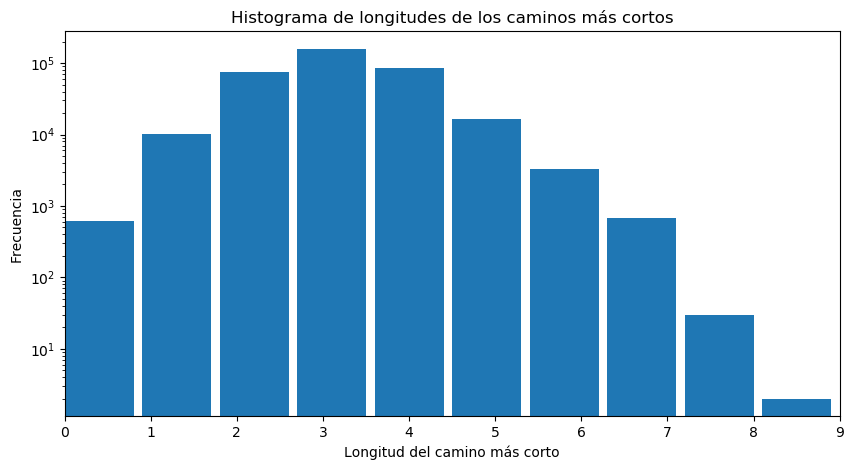

In [ ]:
all_caminos_cortos = dict(nx.all_pairs_shortest_path_length(G)) # Calculo de todos los caminos más cortos: all_pairs_shortest_path_length(G)
caminos_cortos_lengths = [length for source in all_caminos_cortos for target, length in all_caminos_cortos[source].items()]
plt.figure(figsize=(10, 5))
plt.hist(caminos_cortos_lengths, bins=10, range=(0, max(caminos_cortos_lengths)), width=0.8)
plt.title("Histograma de longitudes de los caminos más cortos")
plt.xlabel("Longitud del camino más corto")
plt.ylabel("Frecuencia")
plt.xlim(0,9)
plt.yscale("log")
plt.show()

## Analizamos el coeficiente de clustering

Obtenemos el coeficiente de agrupamiento medio del grafo


In [ ]:
nx.average_clustering(G)

0.22355357916362337

Representamos la distribución del coeficiente de agrupamiento

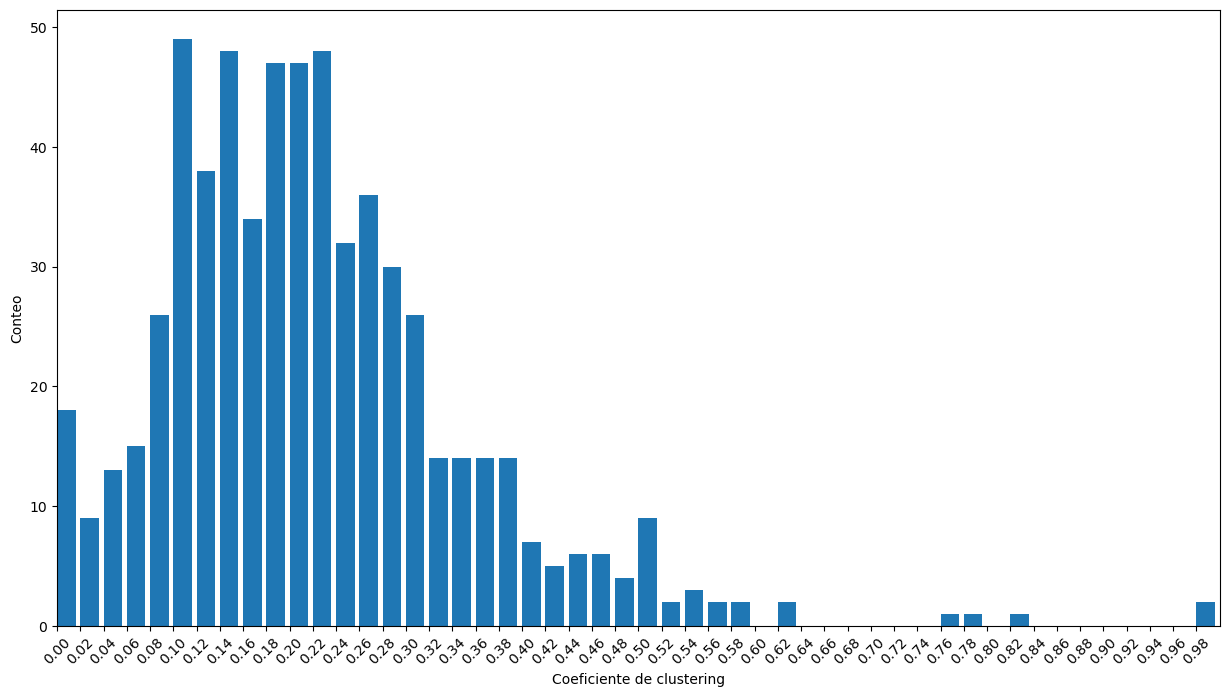

In [ ]:
plt.figure(figsize=(15, 8))
plt.hist(nx.clustering(G).values(), bins=50, width=(1/50)*0.8)
plt.xlabel("Coeficiente de clustering", fontdict={"size": 10})
plt.ylabel("Conteo")
plt.xticks(np.arange(0, 1, 1/50))
plt.xlim(0,1)
plt.tick_params(axis='x', rotation=45, labelsize=10)

# 4. Relevancia de nodos

### ¿Cúal es la distribución de centralidad de cercanía de la red? ¿Cómo se interpreta? ¿Cúal es el elemento más relevante según esta métrica?


Text(0, 0.5, 'Counts')

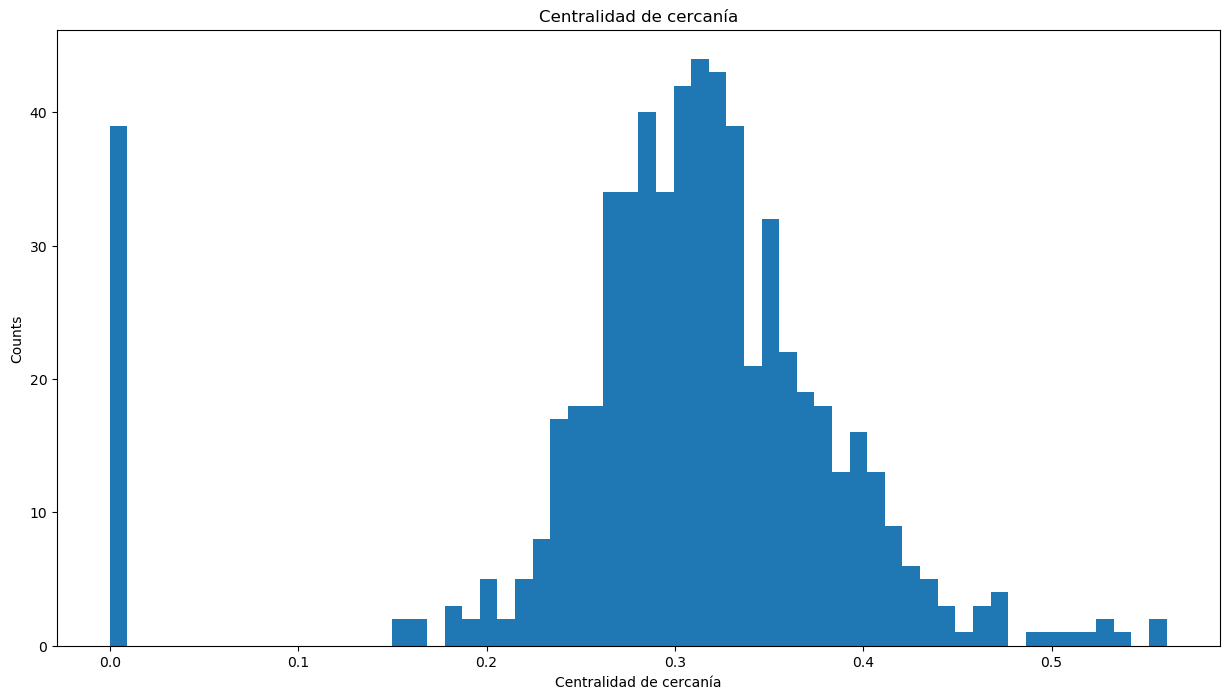

In [ ]:
plt.figure(figsize=(15, 8))
plt.hist(nx.closeness_centrality(G).values(), bins=60)
plt.title("Centralidad de cercanía")
plt.xlabel("Centralidad de cercanía")
plt.ylabel("Counts")

Al tratarse de una red direccional, no queda claro a primera vista el proceso que se sigue para llevar a cabo el cálculo de la medida. Si bien damos por hecho que esta está normalizada, dada la falta de presencia de elementos con valor 1.

La medida es una muestra de la influencia en la red, en tanto que refleja una distancia corta al resto de nodos. Así, el elemento más relevante sería aquel que toma menores valores en su coeficiente de centralidad de cercanía, en este caso entorno al 0,05 (dejando al margen los contenidos en 0). Esto implica un mayor número de relaciones directas con el resto de la red, lo que lleva a una reducción de la distancia media con el conjunto. En otras palabras, este nodo es un nodo con muchas relaciones salientes, es decir, que "sigue" a muchas personas.

El valor del coeficiente 0 en una proporción considerable de los grafos se debe a la inexistencia de grados de salida, lo que se interpreta como la inexistencia de "seguidos" dentro de la muestra obtenida de la red social.

Al margen de aquellos con valor cero, que no significan una cercanía exacerbada, cabe destacar esta medida como signo de la presencia de una tendencia centralizada, donde un achatamiento del pico implicaría una mayor descentralización de la tendencia. Los valores mayores señalan aquellos nodos en la periferia del grafo.

### ¿Cúal es la distribución de la métrica centralidad de intermediación de la red? ¿Cómo interpretas los resultados?




Text(0, 0.5, 'Counts')

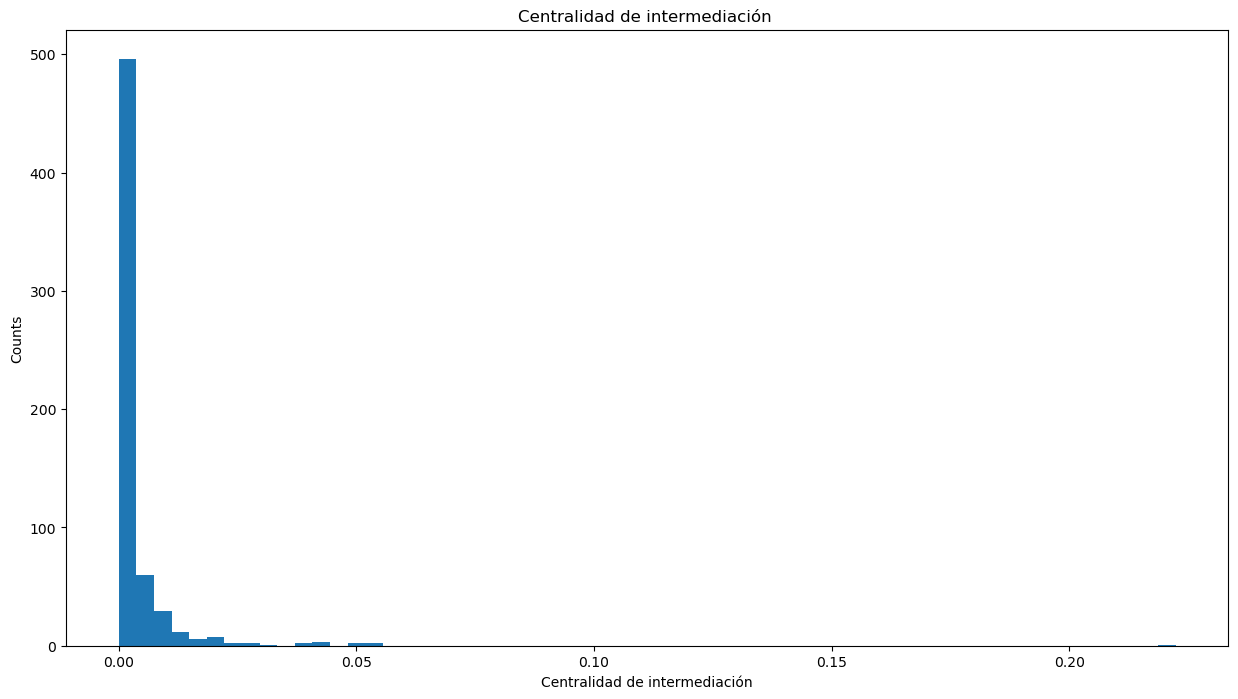

In [ ]:
plt.figure(figsize=(15, 8))
plt.hist(nx.betweenness_centrality(G,normalized = True, endpoints = False, k = 10).values(), bins=60)
plt.title("Centralidad de intermediación ")
plt.xlabel("Centralidad de intermediación")
plt.ylabel("Counts")

La medida nos permite identificar nodos presentes en el conjunto de caminos más cortos con el resto de nodos presentes en los grafos. Entendemos que aquellos que toman valores altos son líderes de opinión capaces de aunar gran cantidad de subgrupos de la comunidad, sirviendo de puente entre usuarios de distintas preferencias, comunidades, gustos o rasgos.

### ¿Cúal es la distribución de la métrica PageRank de la red? ¿cómo lo interpretas?

Text(0, 0.5, 'Counts')

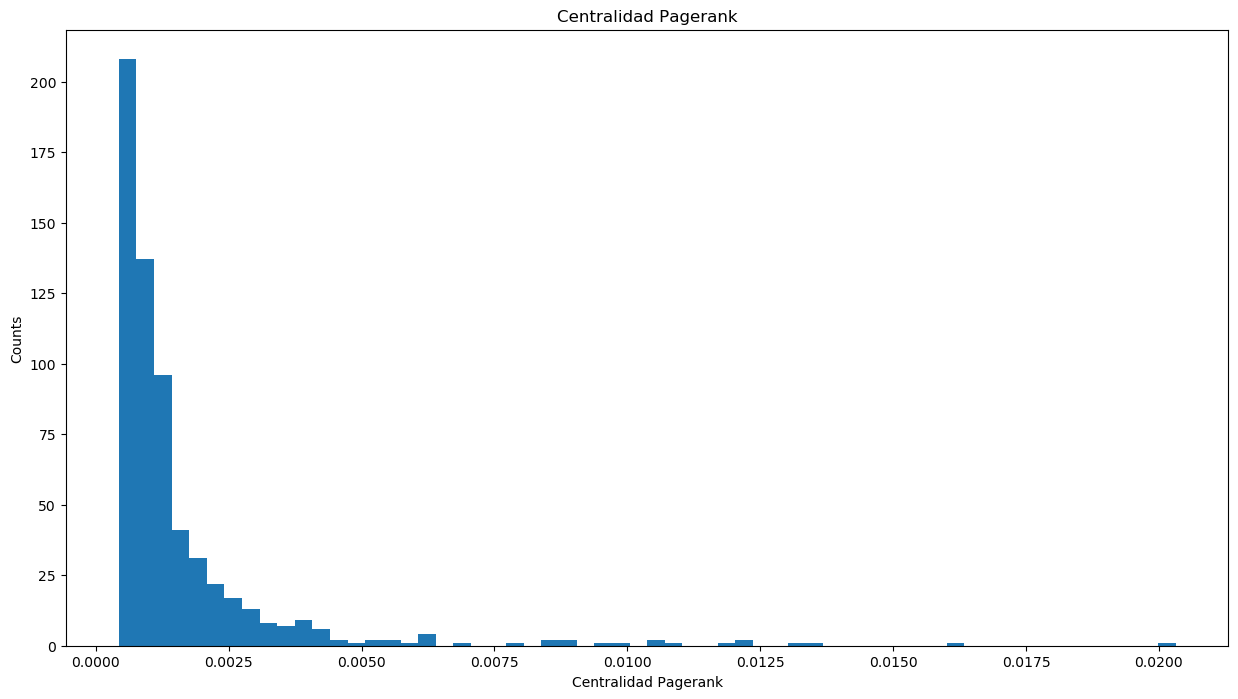

In [ ]:
plt.figure(figsize=(15, 8))
plt.hist(nx.pagerank(G, alpha=0.8).values(), bins=60)
plt.title("Centralidad Pagerank")
plt.xlabel("Centralidad Pagerank")
plt.ylabel("Counts")

La medida suaviza la tendencia previa al considerar la influencia de los nodos de entrada con un factor multiplicador del radio con respecto al total de aristas del nodo del que proviene ese grado de entrada. Aun no siendo el camino más corto dentro de la muestra, algunos nodos sí tienen relaciones de entrada con otros, lo que hace que el acumulado de cero se reduzca notablemente.

### Representamos en un dataframe los nodos el top-20 de nodos con mayor centralidad de cercanía y pagerank. ¿Cúal es la clase asignada a estos nodos? ¿Existe algún patrón?

In [ ]:
closeness_top20 = sorted(nx.closeness_centrality(G).items(), key=lambda item: item[1], reverse=True)[:20]
dict_close =  {t[0]: t[1] for t in closeness_top20}
pagerank_top20 = sorted(nx.pagerank(G, alpha=0.8).items(), key=lambda item: item[1], reverse=True)[:20]
dict_page = {t[0]: t[1] for t in pagerank_top20}

In [ ]:
df = pd.DataFrame({'closeness': dict_close, 'pagerank': dict_page})
df = df.sort_values("closeness",ascending=False)
df = df.rename_axis('id_source')
merged_dataset = pd.merge(df, nodos, on = "id_source")
merged_dataset

,closeness,pagerank,Target,description,grupo
id_source,,,,,
256303752,0.561069,0.012241,256303752,Trabajamos por el Derecho Universal a la #Salu...,asociacion
2974326351,0.554532,0.020313,2974326351,Agrupamos a 33 organizaciones de #pacientes y ...,asociacion
271099251,0.537823,0.010646,271099251,"Información, formación, servicios y trabajo co...",ong
367210075,0.528628,0.013533,367210075,Diario online más influyente en el sector sani...,no_class
1280142038667755520,0.525116,0.016225,1280142038667755520,Somos una Empresa que se dedica a la Virtualiz...,no_class
308131267,0.516828,0.012182,308131267,"Espacio digital de noticias: accesibilidad, di...",no_class
198867180,0.505012,0.013306,198867180,La voz del ciudadano en materia de salud.\n\n🗣...,no_class
847726106937409536,0.501747,0.009446,847726106937409536,El periodismo de las personas. Medio de salud ...,no_class
1327897933036072963,0.492340,0.010967,1327897933036072963,Asociación de #Enfermedades #Raras de #Alcalá ...,asociacion


Existe un patrón de coincidencia derivado del factor aditivo del PageRank con respecto a la centralidad de intermediación.

Es común que los nodos coincidan en posición relativa dentro de ambas distribuciones, por lo que pertenecen a ambos tops. Aun así, aquellos con valores nulos son nodos que, aún tomando altos valores en una distribución, no lo hacen en la otra, en consonancia con lo anterior.

La inclusión del grupo y la descripción no nos lleva a conclusiones muy sólidas. La distribución del grupo que vimos previamente se reproduce más o menos igual en el total de la muestra.

En cuanto a las descripciones, vemos que los nodos son principalmente asociaciones de salud y medios de comunicación, pero no sabemos cómo se compone la mezcla total como para suponer que esta tendencia no se da también en toda la muestra.

# 5. Visualización de la red

Generamos una representación de la red analizada con NetworkX filtrando el número de nodos para obtener resultados de forma más rápida y modificando el tamaño y color de los nodos según su PageRank.

In [ ]:
pos = nx.spring_layout(G, iterations=70,scale=1,seed=1721,dim=2)

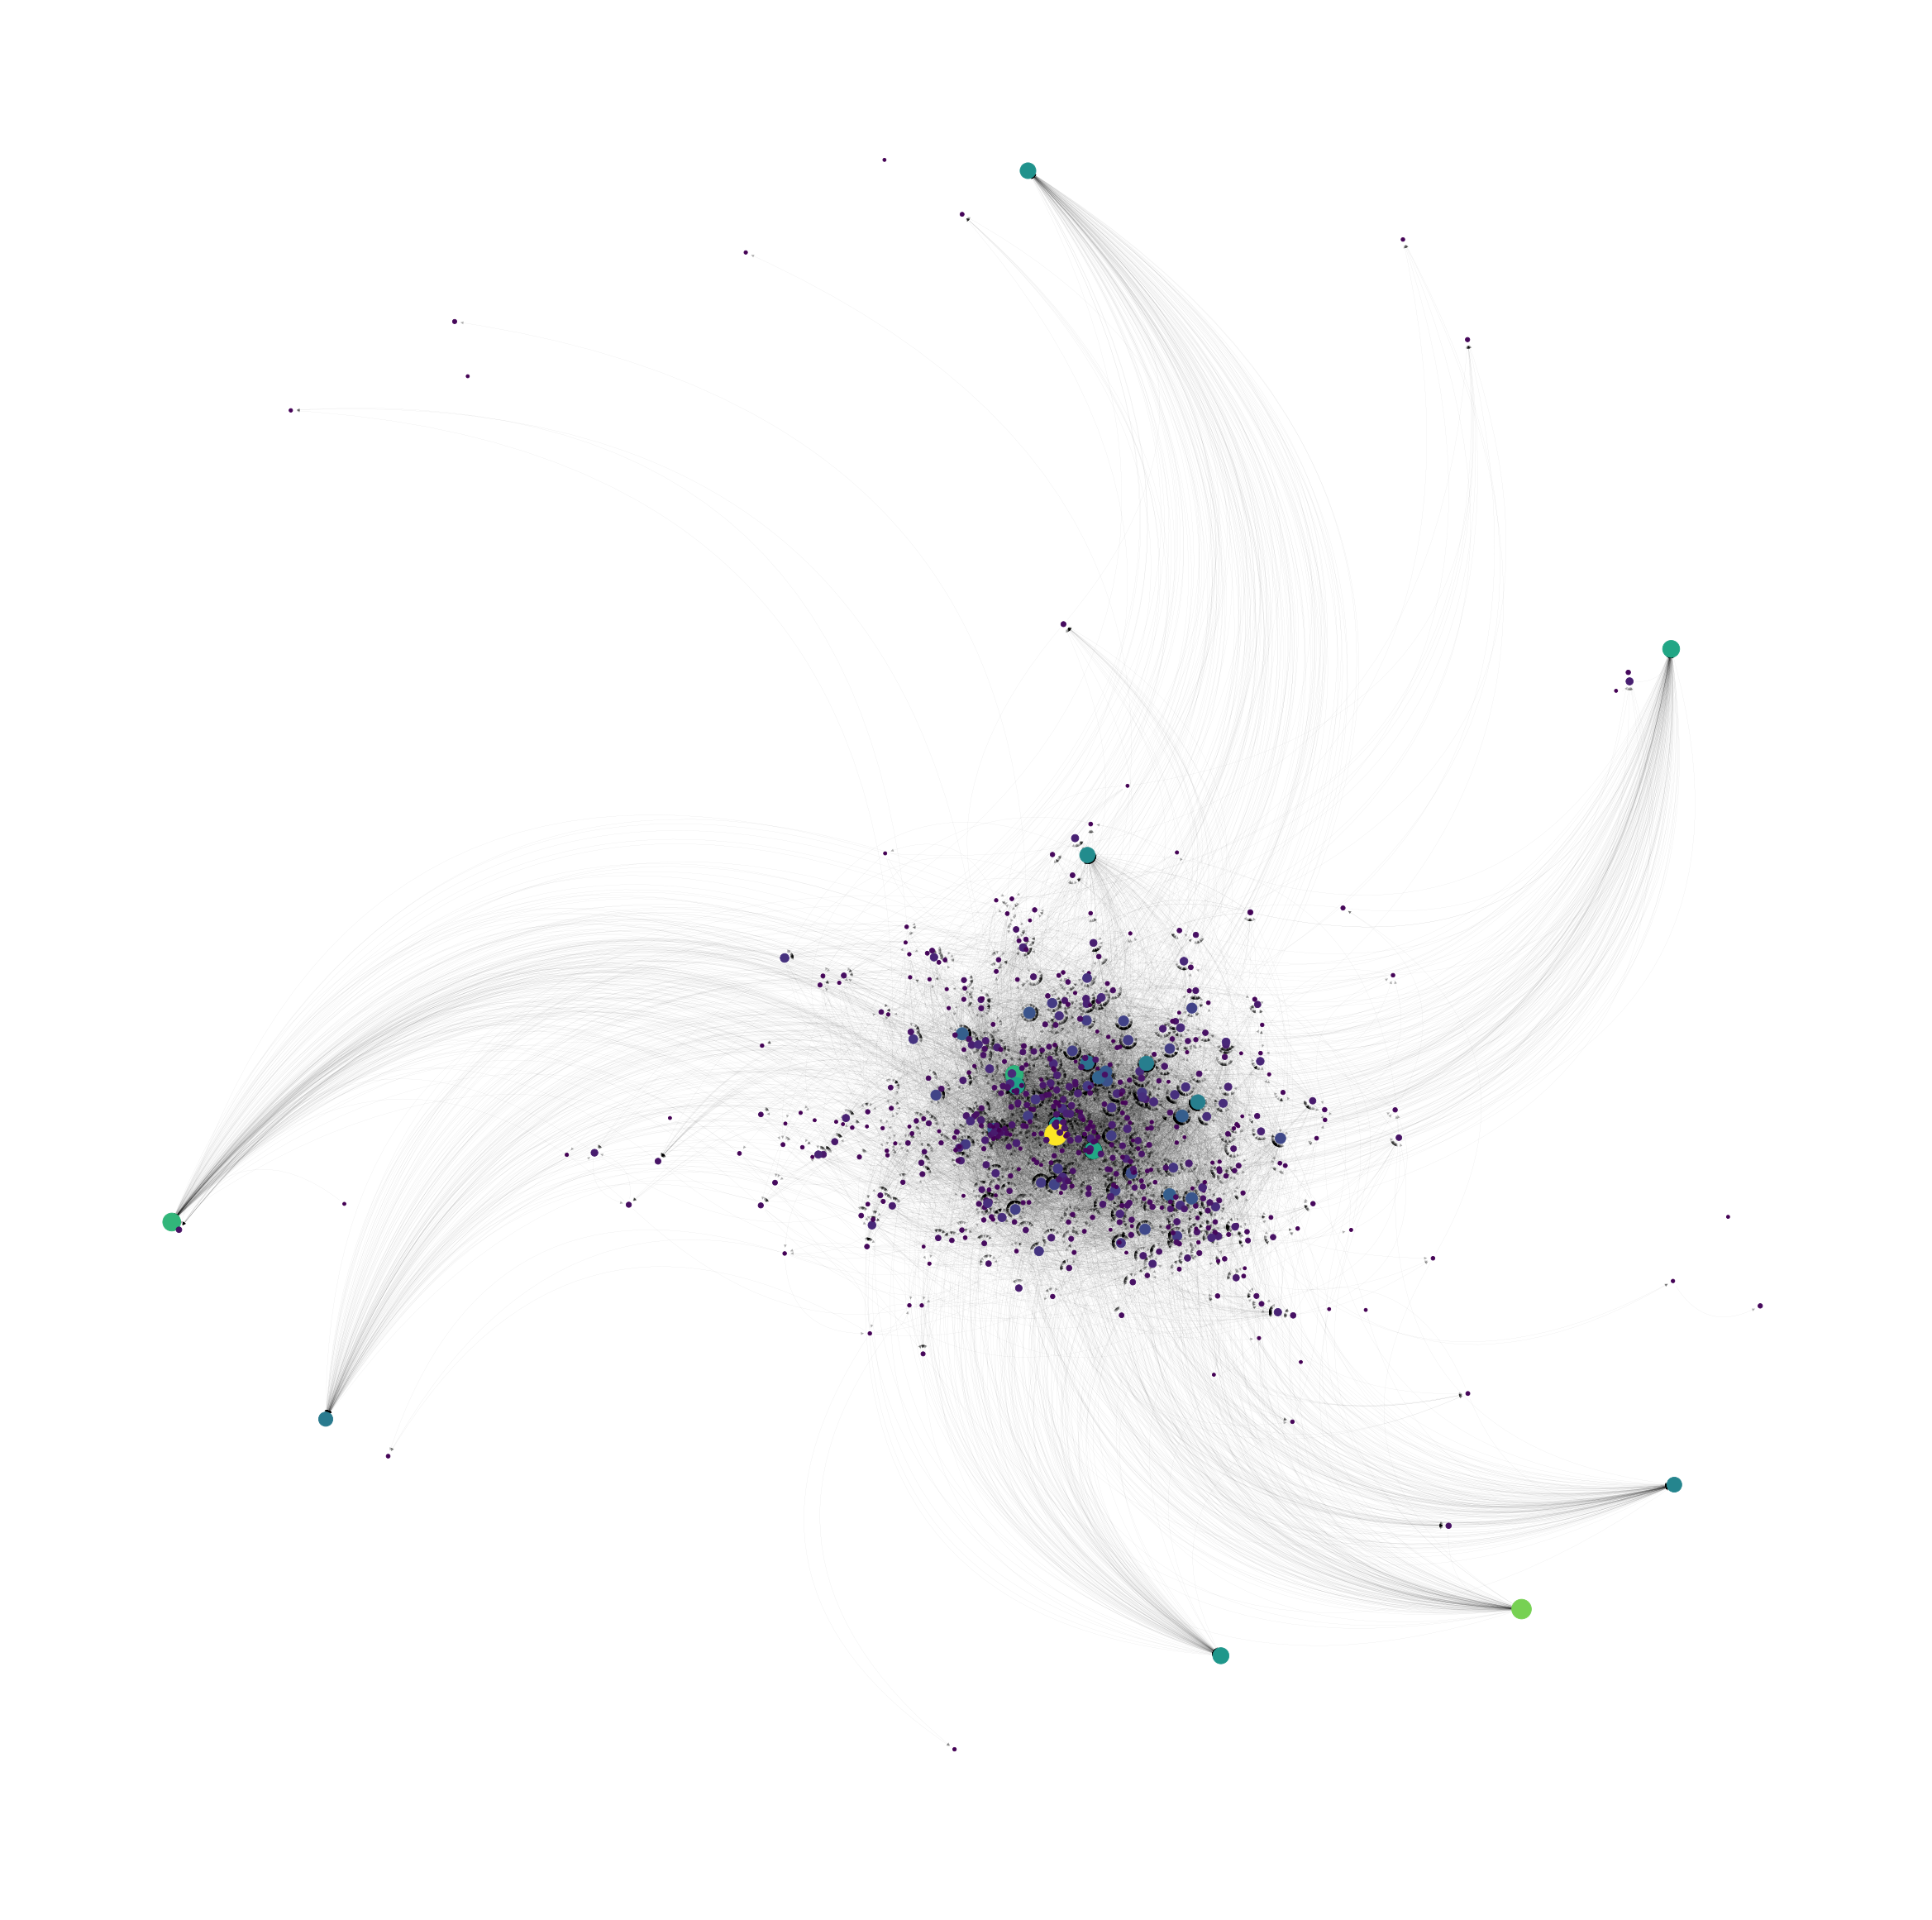

In [ ]:
plt.figure(1, figsize=(50, 50), dpi=60)
pagerank_centrality_G = nx. pagerank(G, alpha=0.8)

node_size = [
    v * 50000 for v in pagerank_centrality_G.values()
]
node_color = [20000.0 * v for v in pagerank_centrality_G.values()]


nx.draw_networkx_nodes(G, pos, node_size=node_size,node_color=node_color, alpha=1)
nx.draw_networkx_edges(G, pos, width=0.1,connectionstyle="arc3,rad=0.5", alpha=0.3)
label_options = {"ec": "k", "fc": "white", "alpha": 0.7}

plt.axis('off');